<a href="https://colab.research.google.com/github/annasajkh/Face-Generator/blob/main/Conv_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWganDJGKzU8nkheC3xKLoN46632d_dNWakvyVPpmHisu1c48z83GJw
Mounted at /content/drive


In [ ]:
import os
os.environ["KAGGLE_CONFIG_DIR"] = "/content/drive/MyDrive/kaggle"

!kaggle datasets download -d greatgamedota/ffhq-face-data-set

In [ ]:
!unzip ffhq-face-data-set.zip

In [5]:
import glob
from PIL import Image
import numpy as np

imgs = []

count = 0

for file in glob.glob("thumbnails128x128/*"):
  imgs.append(np.array(Image.open(file).resize((64,64))) / 255)
  count += 1

  if count == 20_000:
    break

np.save("face_dataset.npy", np.array(imgs))

In [2]:
%cp drive/MyDrive/face_dataset.npy /content/

In [12]:
%cp drive/MyDrive/models/face_model.pkl /content/

In [4]:
from tqdm import tqdm
from torch.nn.modules.linear import Linear
import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
import numpy as np

dataset = torch.from_numpy(np.load("face_dataset.npy")).float()
print(len(dataset))
if torch.cuda.is_available():
  dataset = dataset.cuda()

dataset = dataset.view(len(dataset), 3, 64, 64)

batch_size = 32

20000


In [5]:
class AutoEncoder(nn.Module):
  def __init__(self):
    super(AutoEncoder, self).__init__()

    self.encoder = nn.Sequential(
      nn.Conv2d(3, 120, kernel_size=3, stride=2, padding=1),
      nn.LeakyReLU(True),

      nn.Conv2d(120, 160, kernel_size=3, stride=2, padding=1),
      nn.BatchNorm2d(160),
      nn.LeakyReLU(True),

      nn.Conv2d(160, 200, kernel_size=3, stride=2, padding=0),
      nn.LeakyReLU(True),

      nn.Flatten()
    )

    self.fc1 = nn.Sequential(
      nn.Linear(9800, 600),
      nn.LeakyReLU(True)
    )

    self.fc2 = nn.Sequential(
      nn.Linear(300, 600),
      nn.LeakyReLU(True),

      nn.Linear(600, 9800),
      nn.LeakyReLU(True)
    )


    self.decoder = nn.Sequential(      
      nn.ConvTranspose2d(200, 160, kernel_size=3, stride=2, output_padding=0),
      nn.BatchNorm2d(160),
      nn.ReLU(True),

      nn.ConvTranspose2d(160, 120, kernel_size=5, stride=2, padding=1, output_padding=1),
      nn.BatchNorm2d(120),
      nn.ReLU(True),

      nn.ConvTranspose2d(120, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
      nn.Sigmoid()
    )
  
  def reparameterize(self, mu, log_var):
    """
    :param mu: mean from the encoder's latent space
    :param log_var: log variance from the encoder's latent space
    """
    std = torch.exp(0.5*log_var) # standard deviation
    eps = torch.randn_like(std) # `randn_like` as we need the same size
    sample = mu + (eps * std) # sampling as if coming from the input space
    return sample

  def forward(self, x):
    #code from https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/

    x = self.encode(x).view(-1, 2, 300)

    # get `mu` and `log_var`
    mu = x[:, 0, :] # the first feature values as mean
    log_var = x[:, 1, :] # the other feature values as variance
    # get the latent vector through reparameterization
    z = self.reparameterize(mu, log_var)

    x = self.decode(z)
    return x, mu, log_var
  
  def encode(self, x):
    x = self.encoder(x)
    x = self.fc1(x)
    return x

  def decode(self, x):
    x = self.fc2(x)
    x = x.view(x.shape[0], 200, 7, 7)
    x = self.decoder(x)
    return x

#code from https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [13]:
model = AutoEncoder()
model.load_state_dict(torch.load("face_model.pkl"))
optimizer = Adam(model.parameters(), lr=3e-4)
loss_function = nn.BCELoss(reduction="sum")

if torch.cuda.is_available():
    model = model.cuda()
    loss_function = loss_function.cuda()

In [ ]:
model = AutoEncoder()
optimizer = Adam(model.parameters(), lr=3e-4)
loss_function = nn.BCELoss(reduction="sum")

if torch.cuda.is_available():
    model = model.cuda()
    loss_function = loss_function.cuda()

In [ ]:
model.train()

epoch = 10_000

for e in tqdm(range(epoch)):
  running_loss = 0.0
  for i in range(1, int(len(dataset) / batch_size)):
    data = dataset[(i-1)*batch_size:i*batch_size]
    optimizer.zero_grad()
    reconstruction, mu, logvar = model(data)
    bce_loss = loss_function(reconstruction, data)
    loss = final_loss(bce_loss, mu, logvar)
    running_loss += loss.item()

    loss.backward()
    optimizer.step()
  
  train_loss = running_loss/len(dataset)

  print(f"Epoch: {e}\nLoss: {train_loss}")

  torch.save(model.state_dict(), "drive/MyDrive/models/face_model.pkl")

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 0
Loss: 6801.2010421875


  0%|          | 1/10000 [00:39<109:55:22, 39.58s/it]

Epoch: 1
Loss: 6800.54156875


  0%|          | 2/10000 [01:19<110:02:05, 39.62s/it]

Epoch: 2
Loss: 6800.68301953125


  0%|          | 3/10000 [01:58<109:58:43, 39.60s/it]

Epoch: 3
Loss: 6800.68104921875


  0%|          | 4/10000 [02:38<109:55:06, 39.59s/it]

Epoch: 4
Loss: 6800.76460234375


  0%|          | 5/10000 [03:17<109:52:47, 39.58s/it]

Epoch: 5
Loss: 6800.40800234375


  0%|          | 6/10000 [03:57<109:51:21, 39.57s/it]

Epoch: 6
Loss: 6800.483153125


  0%|          | 7/10000 [04:37<109:50:47, 39.57s/it]

Epoch: 7
Loss: 6800.56015234375


  0%|          | 8/10000 [05:16<109:51:18, 39.58s/it]

Epoch: 8
Loss: 6800.71104296875


  0%|          | 9/10000 [05:56<109:50:25, 39.58s/it]

Epoch: 9
Loss: 6800.35887421875


  0%|          | 10/10000 [06:35<109:48:44, 39.57s/it]

Epoch: 10
Loss: 6800.31747890625


  0%|          | 11/10000 [07:15<109:48:49, 39.58s/it]

Epoch: 11
Loss: 6800.3426140625


  0%|          | 12/10000 [07:54<109:47:54, 39.57s/it]

Epoch: 12
Loss: 6800.27670234375


  0%|          | 13/10000 [08:34<109:46:14, 39.57s/it]

Epoch: 13
Loss: 6800.3443765625


  0%|          | 14/10000 [09:14<109:44:12, 39.56s/it]

Epoch: 14
Loss: 6800.21680234375


  0%|          | 15/10000 [09:53<109:42:52, 39.56s/it]

Epoch: 15
Loss: 6800.02386015625


  0%|          | 16/10000 [10:33<109:40:56, 39.55s/it]

Epoch: 16
Loss: 6799.88377578125


  0%|          | 17/10000 [11:12<109:39:02, 39.54s/it]

Epoch: 17
Loss: 6799.9308125


  0%|          | 18/10000 [11:52<109:39:47, 39.55s/it]

Epoch: 18
Loss: 6799.7484515625


  0%|          | 19/10000 [12:31<109:38:21, 39.55s/it]

Epoch: 19
Loss: 6799.73026015625


  0%|          | 20/10000 [13:11<109:37:53, 39.55s/it]

Epoch: 20
Loss: 6799.6770515625


  0%|          | 21/10000 [13:50<109:38:38, 39.55s/it]

Epoch: 21
Loss: 6799.7277359375


  0%|          | 22/10000 [14:30<109:38:13, 39.56s/it]

Epoch: 22
Loss: 6799.485540625


  0%|          | 23/10000 [15:10<109:38:29, 39.56s/it]

Epoch: 23
Loss: 6799.34664609375


  0%|          | 24/10000 [15:49<109:37:40, 39.56s/it]

Epoch: 24
Loss: 6799.24093046875


  0%|          | 25/10000 [16:29<109:38:32, 39.57s/it]

Epoch: 25
Loss: 6799.292578125


  0%|          | 26/10000 [17:08<109:38:17, 39.57s/it]

Epoch: 26
Loss: 6799.42597265625


  0%|          | 27/10000 [17:48<109:37:58, 39.57s/it]

Epoch: 27
Loss: 6799.106034375


  0%|          | 28/10000 [18:27<109:38:41, 39.58s/it]

Epoch: 28
Loss: 6799.10328671875


  0%|          | 29/10000 [19:07<109:38:54, 39.59s/it]

Epoch: 29
Loss: 6799.3752578125


  0%|          | 30/10000 [19:47<109:38:53, 39.59s/it]

Epoch: 30
Loss: 6799.3221515625


  0%|          | 31/10000 [20:26<109:38:27, 39.59s/it]

Epoch: 31
Loss: 6799.1753140625


  0%|          | 32/10000 [21:06<109:38:51, 39.60s/it]

Epoch: 32
Loss: 6799.0703046875


  0%|          | 33/10000 [21:45<109:37:54, 39.60s/it]

Epoch: 33
Loss: 6798.8534875


  0%|          | 34/10000 [22:25<109:34:48, 39.58s/it]

Epoch: 34
Loss: 6798.72883984375


  0%|          | 35/10000 [23:05<109:34:36, 39.59s/it]

Epoch: 35
Loss: 6798.8922875


  0%|          | 36/10000 [23:44<109:34:01, 39.59s/it]

Epoch: 36
Loss: 6798.8041921875


  0%|          | 37/10000 [24:24<109:33:33, 39.59s/it]

Epoch: 37
Loss: 6798.96067265625


  0%|          | 38/10000 [25:03<109:29:48, 39.57s/it]

Epoch: 38
Loss: 6798.847165625


  0%|          | 39/10000 [25:43<109:21:58, 39.53s/it]

Epoch: 39
Loss: 6798.81096796875


  0%|          | 40/10000 [26:22<109:16:52, 39.50s/it]

Epoch: 40
Loss: 6798.78647421875


  0%|          | 41/10000 [27:02<109:14:08, 39.49s/it]

Epoch: 41
Loss: 6798.7759515625


  0%|          | 42/10000 [27:41<109:09:36, 39.46s/it]

Epoch: 42
Loss: 6798.6585


  0%|          | 43/10000 [28:20<109:07:47, 39.46s/it]

Epoch: 43
Loss: 6798.6773515625


  0%|          | 44/10000 [29:00<109:04:36, 39.44s/it]

Epoch: 44
Loss: 6798.54839453125


  0%|          | 45/10000 [29:39<109:02:34, 39.43s/it]

Epoch: 45
Loss: 6798.39616796875


  0%|          | 46/10000 [30:19<109:01:33, 39.43s/it]

Epoch: 46
Loss: 6798.335046875


  0%|          | 47/10000 [30:58<109:00:33, 39.43s/it]

Epoch: 47
Loss: 6798.3337734375


  0%|          | 48/10000 [31:38<109:00:35, 39.43s/it]

Epoch: 48
Loss: 6798.2654796875


  0%|          | 49/10000 [32:17<108:59:33, 39.43s/it]

Epoch: 49
Loss: 6798.18079296875


  0%|          | 50/10000 [32:56<108:59:14, 39.43s/it]

Epoch: 50
Loss: 6798.25268828125


  1%|          | 51/10000 [33:36<108:58:23, 39.43s/it]

Epoch: 51
Loss: 6798.31680703125


  1%|          | 52/10000 [34:15<108:56:12, 39.42s/it]

Epoch: 52
Loss: 6798.09386953125


  1%|          | 53/10000 [34:55<108:54:08, 39.41s/it]

Epoch: 53
Loss: 6798.19786015625


  1%|          | 54/10000 [35:34<108:53:33, 39.41s/it]

Epoch: 54
Loss: 6797.98400625


  1%|          | 55/10000 [36:13<108:53:20, 39.42s/it]

Epoch: 55
Loss: 6797.894503125


  1%|          | 56/10000 [36:53<108:52:12, 39.41s/it]

Epoch: 56
Loss: 6797.785509375


  1%|          | 57/10000 [37:32<108:50:37, 39.41s/it]

Epoch: 57
Loss: 6797.761971875


  1%|          | 58/10000 [38:12<108:50:25, 39.41s/it]

Epoch: 58
Loss: 6797.692234375


  1%|          | 59/10000 [38:51<108:51:28, 39.42s/it]

Epoch: 59
Loss: 6797.55602109375


  1%|          | 60/10000 [39:31<108:50:43, 39.42s/it]

Epoch: 60
Loss: 6797.62795546875


  1%|          | 61/10000 [40:10<108:49:47, 39.42s/it]

Epoch: 61
Loss: 6797.75815859375


  1%|          | 62/10000 [40:49<108:48:54, 39.42s/it]

Epoch: 62
Loss: 6797.66635390625


  1%|          | 63/10000 [41:29<108:49:03, 39.42s/it]

Epoch: 63
Loss: 6797.7866265625


  1%|          | 64/10000 [42:08<108:47:34, 39.42s/it]

Epoch: 64
Loss: 6797.715009375


  1%|          | 65/10000 [42:48<108:47:47, 39.42s/it]

Epoch: 65
Loss: 6797.64148359375


  1%|          | 66/10000 [43:27<108:46:36, 39.42s/it]

Epoch: 66
Loss: 6797.50046640625


  1%|          | 67/10000 [44:07<108:46:00, 39.42s/it]

Epoch: 67
Loss: 6797.6663703125


  1%|          | 68/10000 [44:46<108:45:09, 39.42s/it]

Epoch: 68
Loss: 6797.26742109375


  1%|          | 69/10000 [45:25<108:46:39, 39.43s/it]

Epoch: 69
Loss: 6797.33427578125


  1%|          | 70/10000 [46:05<108:45:57, 39.43s/it]

Epoch: 70
Loss: 6797.33696171875


  1%|          | 71/10000 [46:44<108:45:25, 39.43s/it]

Epoch: 71
Loss: 6797.3087546875


  1%|          | 72/10000 [47:24<108:44:39, 39.43s/it]

Epoch: 72
Loss: 6797.24003671875


  1%|          | 73/10000 [48:03<108:44:10, 39.43s/it]

Epoch: 73
Loss: 6797.218271875


  1%|          | 74/10000 [48:43<108:43:16, 39.43s/it]

Epoch: 74
Loss: 6797.29475


  1%|          | 75/10000 [49:22<108:42:29, 39.43s/it]

Epoch: 75
Loss: 6796.9747046875


  1%|          | 76/10000 [50:01<108:42:30, 39.43s/it]

Epoch: 76
Loss: 6797.20378828125


  1%|          | 77/10000 [50:41<108:41:45, 39.43s/it]

Epoch: 77
Loss: 6796.9497828125


  1%|          | 78/10000 [51:20<108:40:00, 39.43s/it]

Epoch: 78
Loss: 6796.88155


  1%|          | 79/10000 [52:00<108:39:09, 39.43s/it]

Epoch: 79
Loss: 6796.99675703125


  1%|          | 80/10000 [52:39<108:37:39, 39.42s/it]

Epoch: 80
Loss: 6796.85447421875


  1%|          | 81/10000 [53:19<108:36:56, 39.42s/it]

Epoch: 81
Loss: 6796.92489453125


  1%|          | 82/10000 [53:58<108:35:42, 39.42s/it]

Epoch: 82
Loss: 6796.83366328125


  1%|          | 83/10000 [54:37<108:36:59, 39.43s/it]

Epoch: 83
Loss: 6796.893765625


  1%|          | 84/10000 [55:17<108:40:21, 39.45s/it]

Epoch: 84
Loss: 6797.206846875


  1%|          | 85/10000 [55:56<108:42:06, 39.47s/it]

Epoch: 85
Loss: 6796.9577390625


  1%|          | 86/10000 [56:36<108:39:48, 39.46s/it]

Epoch: 86
Loss: 6797.10101875


  1%|          | 87/10000 [57:15<108:37:25, 39.45s/it]

Epoch: 87
Loss: 6796.93525


  1%|          | 88/10000 [57:55<108:35:12, 39.44s/it]

Epoch: 88
Loss: 6796.8472265625


  1%|          | 89/10000 [58:34<108:33:44, 39.43s/it]

Epoch: 89
Loss: 6796.65423515625


  1%|          | 90/10000 [59:14<108:32:16, 39.43s/it]

Epoch: 90
Loss: 6796.4224296875


  1%|          | 91/10000 [59:53<108:31:06, 39.43s/it]

Epoch: 91
Loss: 6796.667553125


  1%|          | 92/10000 [1:00:32<108:27:48, 39.41s/it]

Epoch: 92
Loss: 6796.59458515625


  1%|          | 93/10000 [1:01:12<108:27:27, 39.41s/it]

Epoch: 93
Loss: 6796.314596875


  1%|          | 94/10000 [1:01:51<108:28:16, 39.42s/it]

Epoch: 94
Loss: 6796.52972265625


  1%|          | 95/10000 [1:02:31<108:26:01, 39.41s/it]

Epoch: 95
Loss: 6796.48246875


  1%|          | 96/10000 [1:03:10<108:25:01, 39.41s/it]

Epoch: 96
Loss: 6796.32074140625


  1%|          | 97/10000 [1:03:49<108:25:05, 39.41s/it]

Epoch: 97
Loss: 6796.3850078125


  1%|          | 98/10000 [1:04:29<108:24:08, 39.41s/it]

Epoch: 98
Loss: 6796.17393671875


  1%|          | 99/10000 [1:05:08<108:24:39, 39.42s/it]

Epoch: 99
Loss: 6796.309671875


  1%|          | 100/10000 [1:05:48<108:25:27, 39.43s/it]

Epoch: 100
Loss: 6796.45099609375


  1%|          | 101/10000 [1:06:27<108:24:47, 39.43s/it]

Epoch: 101
Loss: 6796.2605046875


  1%|          | 102/10000 [1:07:07<108:25:57, 39.44s/it]

Epoch: 102
Loss: 6796.17931796875


  1%|          | 103/10000 [1:07:46<108:26:45, 39.45s/it]

Epoch: 103
Loss: 6796.101246875


  1%|          | 104/10000 [1:08:25<108:26:23, 39.45s/it]

Epoch: 104
Loss: 6796.2232765625


  1%|          | 105/10000 [1:09:05<108:25:58, 39.45s/it]

Epoch: 105
Loss: 6795.9414015625


  1%|          | 106/10000 [1:09:45<108:32:21, 39.49s/it]

Epoch: 106
Loss: 6795.89789609375


  1%|          | 107/10000 [1:10:24<108:38:51, 39.54s/it]

Epoch: 107
Loss: 6795.75063046875


  1%|          | 108/10000 [1:11:04<108:41:52, 39.56s/it]

Epoch: 108
Loss: 6795.72133359375


  1%|          | 109/10000 [1:11:43<108:46:00, 39.59s/it]

Epoch: 109
Loss: 6795.752284375


  1%|          | 110/10000 [1:12:23<108:47:31, 39.60s/it]

Epoch: 110
Loss: 6795.5363203125


  1%|          | 111/10000 [1:13:03<108:48:46, 39.61s/it]

Epoch: 111
Loss: 6795.7820171875


  1%|          | 112/10000 [1:13:42<108:49:27, 39.62s/it]

Epoch: 112
Loss: 6795.627225


  1%|          | 113/10000 [1:14:22<108:49:46, 39.63s/it]

Epoch: 113
Loss: 6795.71518203125


  1%|          | 114/10000 [1:15:02<108:49:17, 39.63s/it]

Epoch: 114
Loss: 6795.54920234375


  1%|          | 115/10000 [1:15:41<108:50:36, 39.64s/it]

Epoch: 115
Loss: 6795.80360625


  1%|          | 116/10000 [1:16:21<108:48:56, 39.63s/it]

Epoch: 116
Loss: 6795.63262578125


  1%|          | 117/10000 [1:17:01<108:48:10, 39.63s/it]

Epoch: 117
Loss: 6795.1976984375


  1%|          | 118/10000 [1:17:40<108:47:26, 39.63s/it]

Epoch: 118
Loss: 6795.49078125


  1%|          | 119/10000 [1:18:20<108:45:10, 39.62s/it]

Epoch: 119
Loss: 6795.48919453125


  1%|          | 120/10000 [1:18:59<108:43:30, 39.62s/it]

Epoch: 120
Loss: 6795.61582421875


  1%|          | 121/10000 [1:19:39<108:40:23, 39.60s/it]

Epoch: 121
Loss: 6795.45996875


  1%|          | 122/10000 [1:20:19<108:40:19, 39.61s/it]

Epoch: 122
Loss: 6795.41968203125


  1%|          | 123/10000 [1:20:58<108:39:32, 39.60s/it]

Epoch: 123
Loss: 6795.39297421875


  1%|          | 124/10000 [1:21:38<108:40:48, 39.62s/it]

Epoch: 124
Loss: 6795.40375234375


  1%|▏         | 125/10000 [1:22:17<108:39:40, 39.61s/it]

Epoch: 125
Loss: 6795.45219296875


  1%|▏         | 126/10000 [1:22:57<108:38:20, 39.61s/it]

Epoch: 126
Loss: 6795.44295390625


  1%|▏         | 127/10000 [1:23:37<108:37:33, 39.61s/it]

Epoch: 127
Loss: 6795.58140703125


  1%|▏         | 128/10000 [1:24:16<108:37:33, 39.61s/it]

Epoch: 128
Loss: 6795.28028828125


  1%|▏         | 129/10000 [1:24:56<108:36:25, 39.61s/it]

Epoch: 129
Loss: 6795.4215796875


  1%|▏         | 130/10000 [1:25:35<108:36:16, 39.61s/it]

Epoch: 130
Loss: 6795.3328921875


  1%|▏         | 131/10000 [1:26:15<108:35:36, 39.61s/it]

Epoch: 131
Loss: 6795.39139609375


  1%|▏         | 132/10000 [1:26:55<108:36:12, 39.62s/it]

Epoch: 132
Loss: 6795.38555703125


  1%|▏         | 133/10000 [1:27:34<108:35:30, 39.62s/it]

Epoch: 133
Loss: 6795.36723671875


  1%|▏         | 134/10000 [1:28:14<108:35:09, 39.62s/it]

Epoch: 134
Loss: 6795.4986078125


  1%|▏         | 135/10000 [1:28:54<108:33:26, 39.62s/it]

Epoch: 135
Loss: 6795.30404453125


  1%|▏         | 136/10000 [1:29:33<108:31:43, 39.61s/it]

Epoch: 136
Loss: 6795.3386375


  1%|▏         | 137/10000 [1:30:13<108:30:53, 39.61s/it]

Epoch: 137
Loss: 6794.9881609375


  1%|▏         | 138/10000 [1:30:52<108:31:10, 39.61s/it]

Epoch: 138
Loss: 6794.91322265625


  1%|▏         | 139/10000 [1:31:32<108:29:29, 39.61s/it]

Epoch: 139
Loss: 6794.89179140625


  1%|▏         | 140/10000 [1:32:12<108:28:49, 39.61s/it]

Epoch: 140
Loss: 6794.938325


  1%|▏         | 141/10000 [1:32:51<108:28:49, 39.61s/it]

Epoch: 141
Loss: 6794.8647


  1%|▏         | 142/10000 [1:33:31<108:28:48, 39.62s/it]

Epoch: 142
Loss: 6794.95379765625


  1%|▏         | 143/10000 [1:34:10<108:27:53, 39.61s/it]

Epoch: 143
Loss: 6794.8426421875


  1%|▏         | 144/10000 [1:34:50<108:26:00, 39.61s/it]

Epoch: 144
Loss: 6794.90764609375


  1%|▏         | 145/10000 [1:35:30<108:25:12, 39.61s/it]

Epoch: 145
Loss: 6794.85826171875


  1%|▏         | 146/10000 [1:36:09<108:25:24, 39.61s/it]

Epoch: 146
Loss: 6794.5727515625


  1%|▏         | 147/10000 [1:36:49<108:25:08, 39.61s/it]

Epoch: 147
Loss: 6794.6565


  1%|▏         | 148/10000 [1:37:28<108:23:41, 39.61s/it]

Epoch: 148
Loss: 6794.62688046875


  1%|▏         | 149/10000 [1:38:08<108:23:57, 39.61s/it]

Epoch: 149
Loss: 6794.4637140625


  2%|▏         | 150/10000 [1:38:48<108:23:40, 39.62s/it]

Epoch: 150
Loss: 6794.535596875


  2%|▏         | 151/10000 [1:39:27<108:22:08, 39.61s/it]

Epoch: 151
Loss: 6794.72844140625


  2%|▏         | 152/10000 [1:40:07<108:20:48, 39.61s/it]

Epoch: 152
Loss: 6794.55684609375


  2%|▏         | 153/10000 [1:40:46<108:20:05, 39.61s/it]

Epoch: 153
Loss: 6794.58780546875


  2%|▏         | 154/10000 [1:41:26<108:20:10, 39.61s/it]

Epoch: 154
Loss: 6794.51624296875


  2%|▏         | 155/10000 [1:42:06<108:20:04, 39.61s/it]

Epoch: 155
Loss: 6794.4035140625


  2%|▏         | 156/10000 [1:42:45<108:19:14, 39.61s/it]

Epoch: 156
Loss: 6794.61890859375


  2%|▏         | 157/10000 [1:43:25<108:19:16, 39.62s/it]

Epoch: 157
Loss: 6794.54418828125


  2%|▏         | 158/10000 [1:44:05<108:20:19, 39.63s/it]

Epoch: 158
Loss: 6794.62360546875


  2%|▏         | 159/10000 [1:44:44<108:19:14, 39.63s/it]

Epoch: 159
Loss: 6794.57236328125


  2%|▏         | 160/10000 [1:45:24<108:18:47, 39.63s/it]

Epoch: 160
Loss: 6794.28588046875


  2%|▏         | 161/10000 [1:46:04<108:19:06, 39.63s/it]

Epoch: 161
Loss: 6794.34222890625


  2%|▏         | 162/10000 [1:46:43<108:19:59, 39.64s/it]

Epoch: 162
Loss: 6794.4510234375


  2%|▏         | 163/10000 [1:47:23<108:19:32, 39.64s/it]

Epoch: 163
Loss: 6794.48714453125


  2%|▏         | 164/10000 [1:48:02<108:19:05, 39.64s/it]

Epoch: 164
Loss: 6794.509334375


  2%|▏         | 165/10000 [1:48:42<108:17:22, 39.64s/it]

Epoch: 165
Loss: 6794.38756328125


  2%|▏         | 166/10000 [1:49:22<108:15:01, 39.63s/it]

Epoch: 166
Loss: 6794.22448671875


  2%|▏         | 167/10000 [1:50:01<108:12:05, 39.61s/it]

Epoch: 167
Loss: 6794.1676078125


  2%|▏         | 168/10000 [1:50:41<108:10:24, 39.61s/it]

Epoch: 168
Loss: 6794.23683515625


  2%|▏         | 169/10000 [1:51:20<108:08:49, 39.60s/it]

Epoch: 169
Loss: 6794.47814609375


  2%|▏         | 170/10000 [1:52:00<108:07:21, 39.60s/it]

Epoch: 170
Loss: 6794.2737171875


  2%|▏         | 171/10000 [1:52:40<108:06:39, 39.60s/it]

Epoch: 171
Loss: 6794.2613


  2%|▏         | 172/10000 [1:53:19<108:06:23, 39.60s/it]

Epoch: 172
Loss: 6794.15256015625


  2%|▏         | 173/10000 [1:53:59<108:06:24, 39.60s/it]

Epoch: 173
Loss: 6794.3337109375


  2%|▏         | 174/10000 [1:54:38<108:05:32, 39.60s/it]

Epoch: 174
Loss: 6794.11266875


  2%|▏         | 175/10000 [1:55:18<108:03:56, 39.60s/it]

Epoch: 175
Loss: 6794.158890625


  2%|▏         | 176/10000 [1:55:58<108:03:32, 39.60s/it]

Epoch: 176
Loss: 6793.87520625


  2%|▏         | 177/10000 [1:56:37<108:03:54, 39.60s/it]

Epoch: 177
Loss: 6794.0840625


  2%|▏         | 178/10000 [1:57:17<108:04:42, 39.61s/it]

Epoch: 178
Loss: 6794.207115625


  2%|▏         | 179/10000 [1:57:57<108:05:42, 39.62s/it]

Epoch: 179
Loss: 6793.871953125


  2%|▏         | 180/10000 [1:58:36<108:06:10, 39.63s/it]

Epoch: 180
Loss: 6793.93468984375


  2%|▏         | 181/10000 [1:59:16<108:05:51, 39.63s/it]

Epoch: 181
Loss: 6793.9876578125


  2%|▏         | 182/10000 [1:59:55<108:03:57, 39.62s/it]

Epoch: 182
Loss: 6794.06230078125


  2%|▏         | 183/10000 [2:00:35<108:04:19, 39.63s/it]

Epoch: 183
Loss: 6793.973590625


  2%|▏         | 184/10000 [2:01:15<108:02:37, 39.62s/it]

Epoch: 184
Loss: 6793.9223828125


  2%|▏         | 185/10000 [2:01:54<108:02:12, 39.63s/it]

Epoch: 185
Loss: 6793.8681140625


  2%|▏         | 186/10000 [2:02:34<108:01:54, 39.63s/it]

Epoch: 186
Loss: 6793.7167421875


  2%|▏         | 187/10000 [2:03:14<108:01:47, 39.63s/it]

Epoch: 187
Loss: 6793.80307421875


  2%|▏         | 188/10000 [2:03:53<108:01:39, 39.64s/it]

Epoch: 188
Loss: 6793.5900625


  2%|▏         | 189/10000 [2:04:33<108:00:29, 39.63s/it]

Epoch: 189
Loss: 6793.707571875


  2%|▏         | 190/10000 [2:05:13<107:59:48, 39.63s/it]

Epoch: 190
Loss: 6793.73377265625


  2%|▏         | 191/10000 [2:05:52<107:58:45, 39.63s/it]

Epoch: 191
Loss: 6793.39586015625


  2%|▏         | 192/10000 [2:06:32<107:56:41, 39.62s/it]

Epoch: 192
Loss: 6793.45949375


  2%|▏         | 193/10000 [2:07:11<107:57:01, 39.63s/it]

Epoch: 193
Loss: 6793.28401953125


  2%|▏         | 194/10000 [2:07:51<107:56:49, 39.63s/it]

Epoch: 194
Loss: 6793.4060765625


  2%|▏         | 195/10000 [2:08:31<107:56:46, 39.63s/it]

Epoch: 195
Loss: 6793.54837109375


  2%|▏         | 196/10000 [2:09:10<107:55:54, 39.63s/it]

Epoch: 196
Loss: 6793.50687890625


  2%|▏         | 197/10000 [2:09:50<107:54:56, 39.63s/it]

Epoch: 197
Loss: 6793.47010234375


  2%|▏         | 198/10000 [2:10:30<107:54:44, 39.63s/it]

Epoch: 198
Loss: 6793.33823828125


  2%|▏         | 199/10000 [2:11:09<107:55:41, 39.64s/it]

Epoch: 199
Loss: 6793.49131328125


  2%|▏         | 200/10000 [2:11:49<107:54:19, 39.64s/it]

Epoch: 200
Loss: 6793.37428671875


  2%|▏         | 201/10000 [2:12:28<107:53:33, 39.64s/it]

Epoch: 201
Loss: 6793.40269765625


  2%|▏         | 202/10000 [2:13:08<107:51:41, 39.63s/it]

Epoch: 202
Loss: 6793.3875578125


  2%|▏         | 203/10000 [2:13:48<107:49:40, 39.62s/it]

Epoch: 203
Loss: 6793.382828125


  2%|▏         | 204/10000 [2:14:27<107:47:57, 39.62s/it]

Epoch: 204
Loss: 6793.2042453125


  2%|▏         | 205/10000 [2:15:07<107:45:24, 39.60s/it]

Epoch: 205
Loss: 6793.14512421875


  2%|▏         | 206/10000 [2:15:46<107:43:41, 39.60s/it]

Epoch: 206
Loss: 6793.40813203125


  2%|▏         | 207/10000 [2:16:26<107:43:43, 39.60s/it]

Epoch: 207
Loss: 6793.37206171875


  2%|▏         | 208/10000 [2:17:06<107:44:20, 39.61s/it]

Epoch: 208
Loss: 6793.44694296875


  2%|▏         | 209/10000 [2:17:45<107:45:15, 39.62s/it]

Epoch: 209
Loss: 6793.34003984375


  2%|▏         | 210/10000 [2:18:25<107:44:16, 39.62s/it]

Epoch: 210
Loss: 6793.078828125


  2%|▏         | 211/10000 [2:19:05<107:42:21, 39.61s/it]

Epoch: 211
Loss: 6793.15531328125


  2%|▏         | 212/10000 [2:19:44<107:44:56, 39.63s/it]

Epoch: 212
Loss: 6793.2584015625


  2%|▏         | 213/10000 [2:20:24<107:51:39, 39.68s/it]

Epoch: 213
Loss: 6793.258859375


  2%|▏         | 214/10000 [2:21:04<107:55:48, 39.70s/it]

Epoch: 214
Loss: 6793.0655734375


  2%|▏         | 215/10000 [2:21:44<107:58:37, 39.73s/it]

Epoch: 215
Loss: 6793.11092265625


  2%|▏         | 216/10000 [2:22:23<108:01:03, 39.74s/it]

Epoch: 216
Loss: 6793.28948671875


  2%|▏         | 217/10000 [2:23:03<108:02:45, 39.76s/it]

Epoch: 217
Loss: 6793.17303515625


  2%|▏         | 218/10000 [2:23:43<107:53:50, 39.71s/it]

Epoch: 218
Loss: 6793.0430328125


  2%|▏         | 219/10000 [2:24:22<107:47:54, 39.68s/it]

Epoch: 219
Loss: 6793.23895703125


  2%|▏         | 220/10000 [2:25:02<107:45:14, 39.66s/it]

Epoch: 220
Loss: 6793.15575078125


  2%|▏         | 221/10000 [2:25:42<107:42:22, 39.65s/it]

Epoch: 221
Loss: 6792.9534421875


  2%|▏         | 222/10000 [2:26:21<107:40:56, 39.65s/it]

Epoch: 222
Loss: 6793.00092421875


  2%|▏         | 223/10000 [2:27:01<107:37:31, 39.63s/it]

Epoch: 223
Loss: 6793.02733984375


  2%|▏         | 224/10000 [2:27:40<107:36:09, 39.62s/it]

Epoch: 224
Loss: 6793.106109375


  2%|▏         | 225/10000 [2:28:20<107:36:13, 39.63s/it]

Epoch: 225
Loss: 6793.1637734375


  2%|▏         | 226/10000 [2:29:00<107:34:38, 39.62s/it]

Epoch: 226
Loss: 6792.7109625


  2%|▏         | 227/10000 [2:29:39<107:32:57, 39.62s/it]

Epoch: 227
Loss: 6792.67442734375


  2%|▏         | 228/10000 [2:30:19<107:32:16, 39.62s/it]

Epoch: 228
Loss: 6792.66868515625


  2%|▏         | 229/10000 [2:30:59<107:32:05, 39.62s/it]

Epoch: 229
Loss: 6792.6472484375


  2%|▏         | 230/10000 [2:31:38<107:32:25, 39.63s/it]

Epoch: 230
Loss: 6792.73289140625


  2%|▏         | 231/10000 [2:32:18<107:32:59, 39.63s/it]

Epoch: 231
Loss: 6792.8041515625


  2%|▏         | 232/10000 [2:32:57<107:32:40, 39.64s/it]

Epoch: 232
Loss: 6792.74883046875


  2%|▏         | 233/10000 [2:33:37<107:31:29, 39.63s/it]

Epoch: 233
Loss: 6792.755146875


  2%|▏         | 234/10000 [2:34:17<107:30:48, 39.63s/it]

Epoch: 234
Loss: 6792.7979015625


  2%|▏         | 235/10000 [2:34:56<107:28:37, 39.62s/it]

Epoch: 235
Loss: 6792.66803828125


  2%|▏         | 236/10000 [2:35:36<107:19:30, 39.57s/it]

Epoch: 236
Loss: 6792.70133828125


  2%|▏         | 237/10000 [2:36:15<107:14:00, 39.54s/it]

Epoch: 237
Loss: 6792.6251296875


  2%|▏         | 238/10000 [2:36:55<107:08:19, 39.51s/it]

Epoch: 238
Loss: 6792.668103125


  2%|▏         | 239/10000 [2:37:34<107:02:44, 39.48s/it]

Epoch: 239
Loss: 6792.6743625


  2%|▏         | 240/10000 [2:38:14<106:59:24, 39.46s/it]

Epoch: 240
Loss: 6792.66795234375


  2%|▏         | 241/10000 [2:38:53<106:57:49, 39.46s/it]

Epoch: 241
Loss: 6792.67754375


  2%|▏         | 242/10000 [2:39:32<106:56:16, 39.45s/it]

Epoch: 242
Loss: 6792.66463359375


  2%|▏         | 243/10000 [2:40:12<106:56:00, 39.45s/it]

Epoch: 243
Loss: 6792.57414296875


  2%|▏         | 244/10000 [2:40:51<106:55:08, 39.45s/it]

Epoch: 244
Loss: 6792.4257265625


  2%|▏         | 245/10000 [2:41:31<106:56:04, 39.46s/it]

Epoch: 245
Loss: 6792.48684296875


  2%|▏         | 246/10000 [2:42:10<106:55:16, 39.46s/it]

Epoch: 246
Loss: 6792.5666640625


  2%|▏         | 247/10000 [2:42:50<106:57:34, 39.48s/it]

Epoch: 247
Loss: 6792.55498046875


  2%|▏         | 248/10000 [2:43:29<106:55:01, 39.47s/it]

Epoch: 248
Loss: 6792.44864765625


  2%|▏         | 249/10000 [2:44:09<106:53:01, 39.46s/it]

Epoch: 249
Loss: 6792.46985859375


  2%|▎         | 250/10000 [2:44:48<106:51:23, 39.45s/it]

Epoch: 250
Loss: 6792.64965546875


  3%|▎         | 251/10000 [2:45:28<106:49:55, 39.45s/it]

Epoch: 251
Loss: 6792.57198515625


  3%|▎         | 252/10000 [2:46:07<106:49:13, 39.45s/it]

Epoch: 252
Loss: 6792.5225375


  3%|▎         | 253/10000 [2:46:46<106:48:24, 39.45s/it]

Epoch: 253
Loss: 6792.277371875


  3%|▎         | 254/10000 [2:47:26<106:47:47, 39.45s/it]

Epoch: 254
Loss: 6792.31134609375


  3%|▎         | 255/10000 [2:48:05<106:46:59, 39.45s/it]

Epoch: 255
Loss: 6792.37649296875


  3%|▎         | 256/10000 [2:48:45<106:46:21, 39.45s/it]

Epoch: 256
Loss: 6792.47890703125


  3%|▎         | 257/10000 [2:49:24<106:45:28, 39.45s/it]

Epoch: 257
Loss: 6792.44697890625


  3%|▎         | 258/10000 [2:50:04<106:43:35, 39.44s/it]

Epoch: 258
Loss: 6792.19138515625


  3%|▎         | 259/10000 [2:50:43<106:43:53, 39.44s/it]

Epoch: 259
Loss: 6792.27036640625


  3%|▎         | 260/10000 [2:51:23<106:44:15, 39.45s/it]

Epoch: 260
Loss: 6792.2485640625


  3%|▎         | 261/10000 [2:52:02<106:44:07, 39.45s/it]

Epoch: 261
Loss: 6792.1636203125


  3%|▎         | 262/10000 [2:52:41<106:43:58, 39.46s/it]

Epoch: 262
Loss: 6792.46131953125


  3%|▎         | 263/10000 [2:53:21<106:42:17, 39.45s/it]

Epoch: 263
Loss: 6792.21013828125


  3%|▎         | 264/10000 [2:54:00<106:41:13, 39.45s/it]

Epoch: 264
Loss: 6792.30070390625


  3%|▎         | 265/10000 [2:54:40<106:40:21, 39.45s/it]

Epoch: 265
Loss: 6792.30535390625


  3%|▎         | 266/10000 [2:55:19<106:39:12, 39.44s/it]

Epoch: 266
Loss: 6792.20581171875


  3%|▎         | 267/10000 [2:55:59<106:38:12, 39.44s/it]

Epoch: 267
Loss: 6792.2928609375


  3%|▎         | 268/10000 [2:56:38<106:37:46, 39.44s/it]

Epoch: 268
Loss: 6792.25128515625


  3%|▎         | 269/10000 [2:57:18<106:36:07, 39.44s/it]

Epoch: 269
Loss: 6792.14735703125


  3%|▎         | 270/10000 [2:57:57<106:34:51, 39.43s/it]

Epoch: 270
Loss: 6792.37288671875


  3%|▎         | 271/10000 [2:58:36<106:35:07, 39.44s/it]

Epoch: 271
Loss: 6792.36744921875


  3%|▎         | 272/10000 [2:59:16<106:34:46, 39.44s/it]

Epoch: 272
Loss: 6792.41433203125


  3%|▎         | 273/10000 [2:59:55<106:33:20, 39.44s/it]

Epoch: 273
Loss: 6792.08669609375


  3%|▎         | 274/10000 [3:00:35<106:33:46, 39.44s/it]

Epoch: 274
Loss: 6792.2783265625


  3%|▎         | 275/10000 [3:01:14<106:32:57, 39.44s/it]

Epoch: 275
Loss: 6792.03356015625


  3%|▎         | 276/10000 [3:01:54<106:32:00, 39.44s/it]

Epoch: 276
Loss: 6792.1508453125


  3%|▎         | 277/10000 [3:02:33<106:30:54, 39.44s/it]

Epoch: 277
Loss: 6792.26760625


  3%|▎         | 278/10000 [3:03:12<106:29:46, 39.43s/it]

In [ ]:
print(len(dataset))

20000


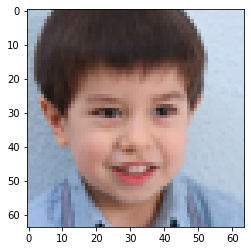

In [ ]:
import matplotlib.pyplot as plt

model.eval()
plt.imshow(dataset[0].cpu().reshape(64, 64, 3))

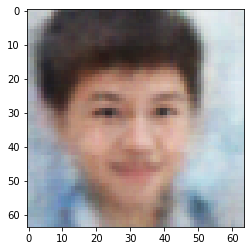

In [ ]:
reconstruction, mu, logvar = model(dataset[0].view(1, 3, 64, 64))
plt.imshow(reconstruction.cpu().detach().reshape(64, 64, 3))